In [2]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

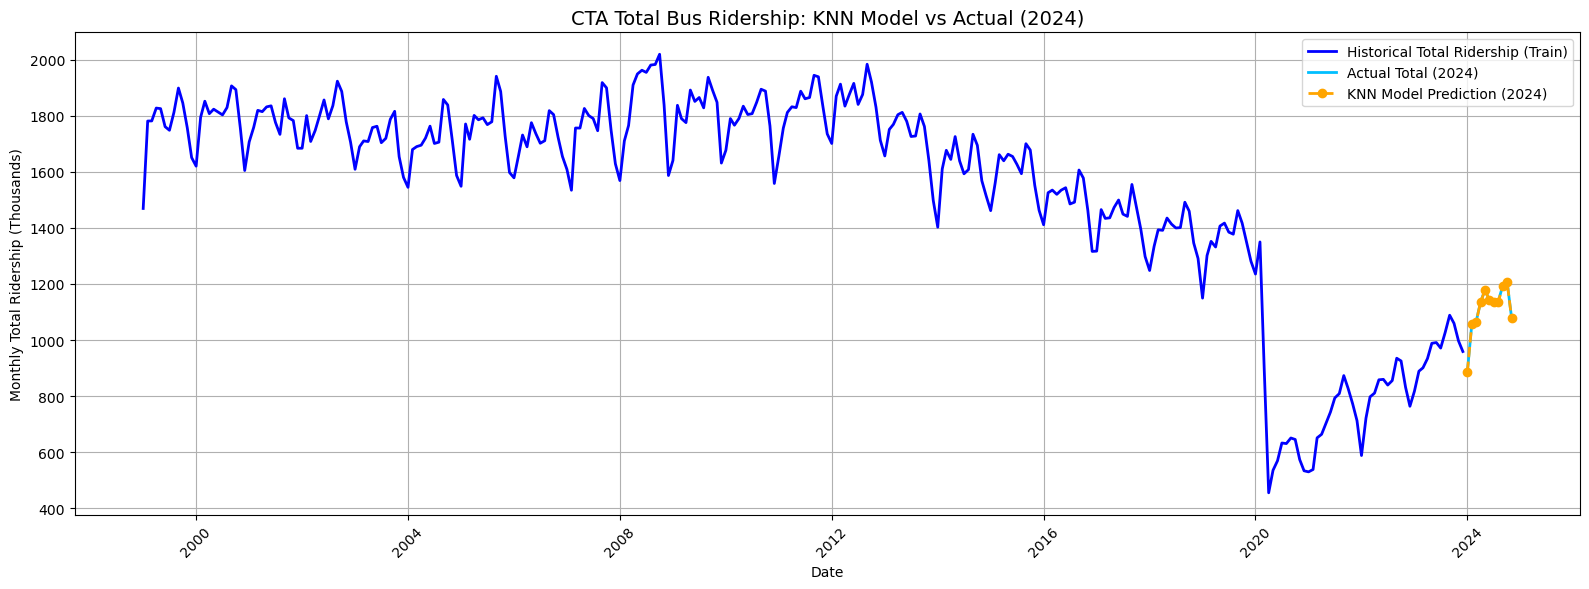

Mean Squared Error (MSE): 12088.46
R² Score: 0.9999


In [3]:

file_path = "CTA_Average_Bus_Ridership_1999_2024_cleaned.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

# Convert date column and extract time features
df["month"] = pd.to_datetime(df["DATE"])
df["year"] = df["month"].dt.year
df["month_num"] = df["month"].dt.month


le = LabelEncoder()
df["route_encoded"] = le.fit_transform(df["BUS"])

# Define features and target 
features = [
    "route_encoded",
    "year",
    "month_num",
    "Weekday",
    "Saturday",
    "Sunday - Holiday"
]
target = "Sum"

# Split data
train_df = df[df["month"] <= "2023-12-31"]
test_df = df[df["month"] >= "2024-01-01"]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Train KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)

# Add predictions to test dataframe
test_df = test_df.copy()
test_df["predicted"] = y_pred

#Aggregate total ridership by month
train_total = train_df.groupby("month")["Sum"].sum().reset_index()
test_total_actual = test_df.groupby("month")["Sum"].sum().reset_index()
test_total_pred = test_df.groupby("month")["predicted"].sum().reset_index()

#Plot 
plt.figure(figsize=(16, 6))

# Blue: historical actuals (training)
plt.plot(train_total["month"], train_total["Sum"] / 1000, color='blue',
         label="Historical Total Ridership (Train)", linewidth=2)

# Light blue: actual 2024
plt.plot(test_total_actual["month"], test_total_actual["Sum"] / 1000, color='deepskyblue',
         label="Actual Total (2024)", linewidth=2)

# Orange dashed: KNN prediction
plt.plot(test_total_pred["month"], test_total_pred["predicted"] / 1000,
         color='orange', linestyle='--', marker='o', linewidth=2,
         label="KNN Model Prediction (2024)")

# plot
plt.title("CTA Total Bus Ridership: KNN Model vs Actual (2024)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Monthly Total Ridership (Thousands)")
plt.legend(loc="best")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")




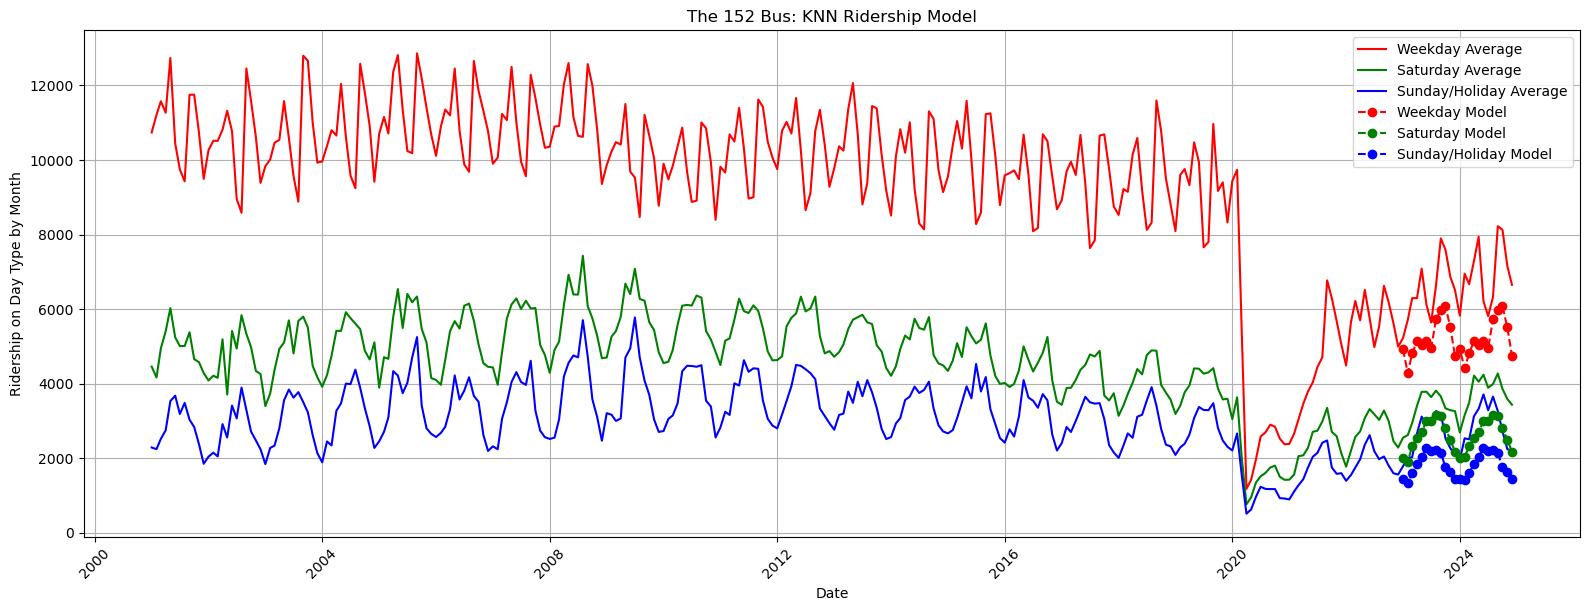

Weekday Prediction Metrics for Route 152:
Mean Squared Error (MSE): 2695338.34
R² Score: -3.0740
Saturday Prediction Metrics for Route 152:
Mean Squared Error (MSE): 953017.01
R² Score: -3.0463
Sunday Prediction Metrics for Route 152:
Mean Squared Error (MSE): 886129.82
R² Score: -1.8721


In [4]:

#knn model for single bus 
df_raw_152 = pd.read_csv("CTA_-_Ridership_-_Bus_Routes_-_Monthly_Day-Type_Averages___Totals_20250530.csv")
df_raw_152['Month_Beginning'] = pd.to_datetime(df_raw_152['Month_Beginning'])
df_raw_152['year'] = df_raw_152['Month_Beginning'].dt.year
df_raw_152['month'] = df_raw_152['Month_Beginning'].dt.month

# 152
df_152_knn = df_raw_152[df_raw_152['route'] == '152'].copy()
df_152_knn.rename(columns={
    'Avg_Weekday_Rides': 'Weekday',
    'Avg_Saturday_Rides': 'Saturday',
    'Avg_Sunday-Holiday_Rides': 'Sunday'
}, inplace=True)
df_152_knn.dropna(subset=['Weekday', 'Saturday', 'Sunday'], inplace=True)

# split
train_152 = df_152_knn[df_152_knn['year'] <= 2022]
test_152 = df_152_knn[df_152_knn['year'] >= 2023]

#Feature scaling
features = ['year', 'month']
scaler_152 = StandardScaler()
X_train_152 = scaler_152.fit_transform(train_152[features])
X_test_152 = scaler_152.transform(test_152[features])

#Train and predict per day type
predictions_152 = {}
metrics_152 = {}

for target in ['Weekday', 'Saturday', 'Sunday']:
    y_train_target = train_152[target]
    y_test_target = test_152[target]
    
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train_152, y_train_target)
    y_pred_target = knn.predict(X_test_152)

    predictions_152[target] = y_pred_target

    # Evaluate
    mse = mean_squared_error(y_test_target, y_pred_target)
    r2 = r2_score(y_test_target, y_pred_target)
    metrics_152[target] = {'MSE': mse, 'R2': r2}

# Sort the dataframes by Month_Beginning for correct chronological plotting
df_152_knn_sorted = df_152_knn.sort_values('Month_Beginning')
test_152_sorted = test_152.sort_values('Month_Beginning')

#Plot actual vs predicted
plt.figure(figsize=(16, 6))

# Actual values
plt.plot(df_152_knn_sorted['Month_Beginning'], df_152_knn_sorted['Weekday'], color='red', label='Weekday Average')
plt.plot(df_152_knn_sorted['Month_Beginning'], df_152_knn_sorted['Saturday'], color='green', label='Saturday Average')
plt.plot(df_152_knn_sorted['Month_Beginning'], df_152_knn_sorted['Sunday'], color='blue', label='Sunday/Holiday Average')

# Predicted values (2023+)
plt.plot(test_152_sorted['Month_Beginning'], predictions_152['Weekday'], 'r--', marker='o', label='Weekday Model')
plt.plot(test_152_sorted['Month_Beginning'], predictions_152['Saturday'], 'g--', marker='o', label='Saturday Model')
plt.plot(test_152_sorted['Month_Beginning'], predictions_152['Sunday'], 'b--', marker='o', label='Sunday/Holiday Model')

# Final plot settings
plt.title("The 152 Bus: KNN Ridership Model")
plt.xlabel("Date")
plt.ylabel("Ridership on Day Type by Month")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()



for day_type, scores in metrics_152.items():
    print(f"{day_type} Prediction Metrics for Route 152:")
    print(f"Mean Squared Error (MSE): {scores['MSE']:.2f}")
    print(f"R² Score: {scores['R2']:.4f}")


